# Generative Adversarial Networks

In [1]:
import tensorflow as tf
from tensorflow.keras.models import save_model
#from tensorflow.python.framework import ops
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential
#import tensorflow.compat.v1.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
import matplotlib.pyplot as plt
#import keras_utils
plt.rcParams.update({'axes.titlesize': 'small'})
from sklearn.datasets import load_digits

In [2]:
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

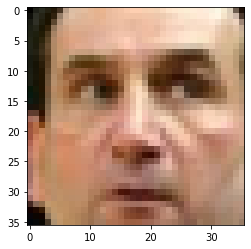

In [3]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="noise_to_face.png" width="400px"/>
_© torch.github.io_

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [4]:
CODE_SIZE = 256 

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(8*8*10, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))

In [5]:
generator.summary() #Note the final layer is size of our image i.e. 36*36*3

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               164480    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 64)        16064     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        102464    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 34, 34, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 36, 36, 32)        9

In [6]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [7]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(32, kernel_size=3, activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(64, kernel_size=3, activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(128, kernel_size=3, activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

In [8]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 34, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)              

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="gan.png" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [9]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [10]:
noise = sample_noise_batch(100)
real_data = sample_data_batch(100)

In [11]:
logp_real = discriminator(real_data)
logp_real

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[-0.9148942 , -0.51175773],
       [-0.89708835, -0.5238352 ],
       [-0.90058917, -0.521432  ],
       [-0.939651  , -0.49554974],
       [-0.8877214 , -0.53033555],
       [-0.8573372 , -0.5521519 ],
       [-0.8601724 , -0.55006754],
       [-0.8147942 , -0.5847062 ],
       [-0.8728019 , -0.5409057 ],
       [-0.83093745, -0.57206416],
       [-0.8735338 , -0.54038095],
       [-0.9250352 , -0.5050382 ],
       [-0.8874289 , -0.5305403 ],
       [-0.8366669 , -0.5676638 ],
       [-0.8596815 , -0.5504276 ],
       [-0.8703226 , -0.5426886 ],
       [-0.90780663, -0.51652205],
       [-0.9451434 , -0.49204284],
       [-0.8710276 , -0.5421809 ],
       [-0.892837  , -0.5267728 ],
       [-0.88490283, -0.5323119 ],
       [-0.8833293 , -0.53341943],
       [-0.88633966, -0.5313033 ],
       [-0.7938147 , -0.60169315],
       [-0.87360203, -0.5403321 ],
       [-0.8658634 , -0.5459144 ],
       [-0.9008485 , -0.5212545 ],
     

In [12]:
generated_data = generator(noise) # <gen(noise)>
generated_data

<tf.Tensor: shape=(100, 36, 36, 3), dtype=float32, numpy=
array([[[[ 1.87697262e-03,  6.41471148e-03,  4.13721707e-03],
         [ 7.26291724e-03, -4.46158648e-03,  1.58128347e-02],
         [ 8.73995665e-03, -7.57385790e-03, -4.86457394e-03],
         ...,
         [-1.79606117e-02, -5.00094192e-03,  3.30397952e-03],
         [-9.47496574e-03, -8.49485025e-03,  6.59511983e-03],
         [ 1.38082448e-03, -1.43409055e-03,  3.01481597e-03]],

        [[ 2.39119586e-03, -2.85016559e-03,  1.58284605e-03],
         [ 7.65816448e-03, -5.96933067e-04,  1.16269970e-02],
         [ 8.19147099e-03,  2.98484638e-02, -3.13512888e-03],
         ...,
         [-1.19208228e-02,  7.90926162e-03, -4.56495117e-03],
         [-1.51519086e-02,  1.05021680e-02, -1.08848941e-02],
         [-8.77256505e-03, -7.13549927e-03, -6.47637062e-03]],

        [[ 2.98767537e-03, -8.71700048e-03,  3.38517129e-05],
         [ 4.35765926e-03,  2.68024765e-03, -1.18876696e-02],
         [-3.49287502e-03,  2.94135865e-02

In [13]:
logp_gen = discriminator(generated_data) #<log P(real | gen(noise))
logp_gen

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[-0.68408823, -0.702289  ],
       [-0.66639113, -0.72063875],
       [-0.6635308 , -0.7236674 ],
       [-0.6965212 , -0.6897844 ],
       [-0.664935  , -0.72217846],
       [-0.7057117 , -0.6807385 ],
       [-0.698258  , -0.68806225],
       [-0.6302738 , -0.7602405 ],
       [-0.73455507, -0.65338594],
       [-0.69530505, -0.6909939 ],
       [-0.6023702 , -0.79299486],
       [-0.65873003, -0.7287911 ],
       [-0.6986705 , -0.6876541 ],
       [-0.6929271 , -0.6933674 ],
       [-0.68166703, -0.7047607 ],
       [-0.7623208 , -0.6284506 ],
       [-0.6645427 , -0.7225941 ],
       [-0.6771113 , -0.7094443 ],
       [-0.7064541 , -0.6800151 ],
       [-0.6757826 , -0.7108186 ],
       [-0.75420773, -0.6356014 ],
       [-0.73417693, -0.65373474],
       [-0.69876707, -0.6875586 ],
       [-0.73281795, -0.6549903 ],
       [-0.7056917 , -0.6807581 ],
       [-0.7211207 , -0.66593486],
       [-0.6847514 , -0.70161396],
     

In [14]:
########################
#discriminator loss
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
#d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

d_loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.2314929>

For more interaction with gradients at each step.

In [15]:
## Compute the gradients for a list of variables.
#with tf.GradientTape() as tape:
#    d_loss = -tf.reduce_mean(discriminator(real_data)[:,1] + discriminator(generated_data)[:,0])

#variables = discriminator.trainable_weights
#grads = tape.gradient(d_loss, variables)
#grads

##Process the gradients, for example cap them, etc.
#processed_grads = [process_gradient(g) for g in grads]
#processed_grads

## Ask the optimizer to apply the processed gradients.
#opt.apply_gradients(zip(processed_grads, variables))

In [16]:
########################
#discriminator training#
########################

# Create an optimizer with the desired parameters.
dis_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# `loss` is a callable that takes no argument and returns the value to minimize.
d_loss = lambda: -tf.reduce_mean(discriminator(real_data)[:,1] + discriminator(generator(noise))[:,0])

## In eager mode, simply call minimize to update the list of variables.
#dis_opt.minimize(d_loss, var_list=discriminator.trainable_weights)

In [17]:
########################
###generator loss###
########################
g_loss = -tf.reduce_mean(logp_gen[:,1]) # <generator loss>
g_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.69410616>

In [18]:
########################
###generator training###
########################
# Create an optimizer with the desired parameters.
gen_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# `loss` is a callable that takes no argument and returns the value to minimize.
g_loss = lambda: -tf.reduce_mean(discriminator(generator(noise))[:,1])

## In eager mode, simply call minimize to update the list of variables.
#gen_opt.minimize(g_loss, var_list=generator.trainable_weights)

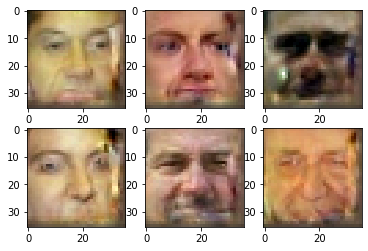

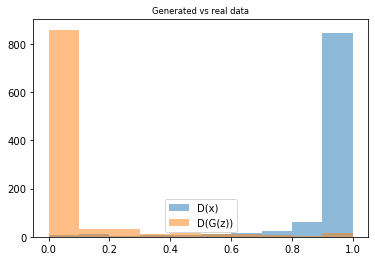

In [20]:
from IPython import display

for epoch in range(50000):
    
    real_data = sample_data_batch(100),
    noise = sample_noise_batch(100)
    
    for i in range(5):
        dis_opt.minimize(d_loss, var_list=discriminator.trainable_weights)

    gen_opt.minimize(g_loss, var_list=generator.trainable_weights)

    if epoch %1000==0:
        print(epoch)
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)

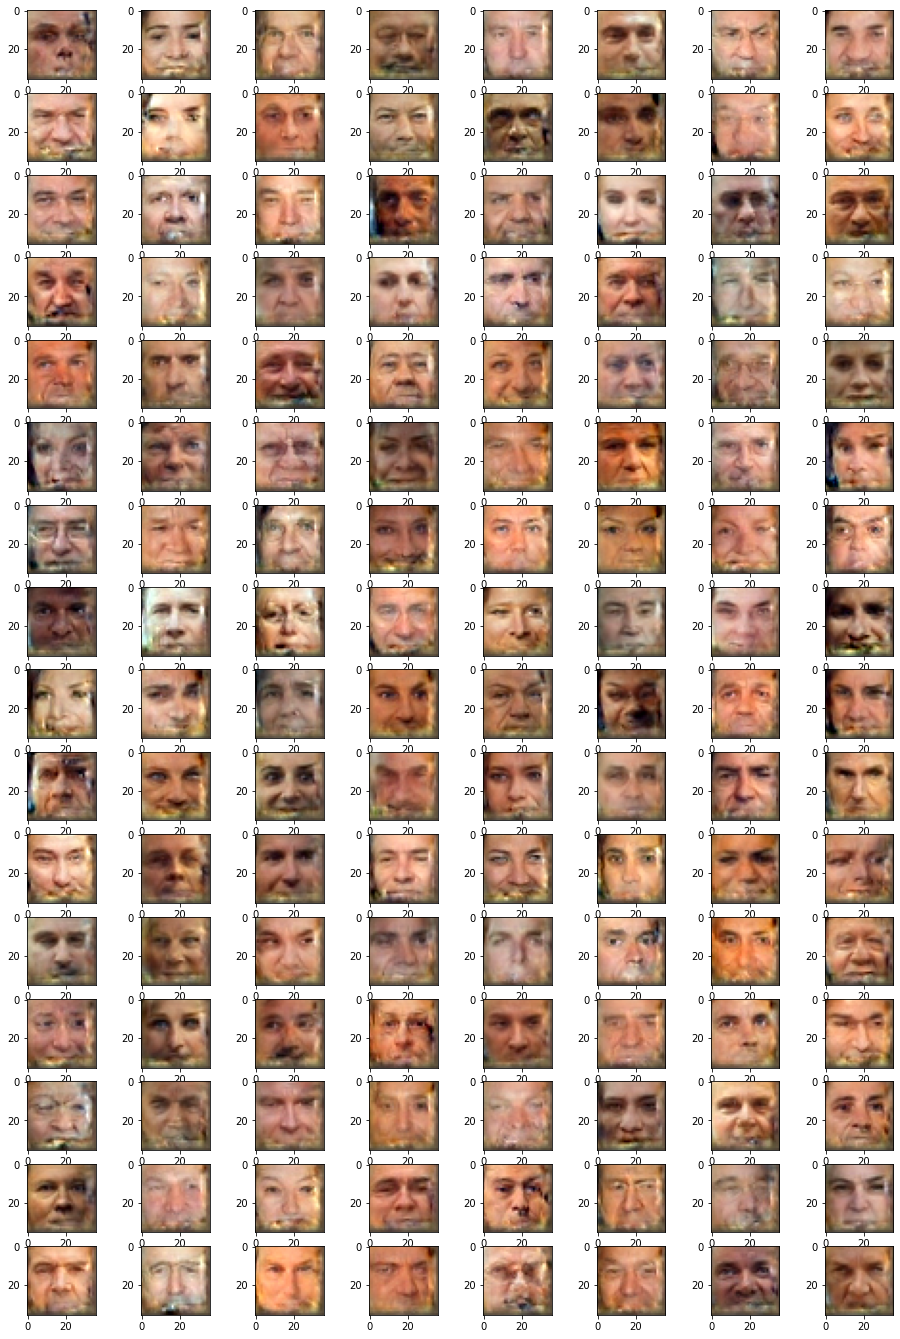

In [21]:
#The network was trained for about 50k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8) 